# Electron Acoustic Waves (Theory): Two-kappa Electrons Model

In [1]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import scipy.signal
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from prettytable import PrettyTable
from scipy import fftpack
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

## Models
### 1D plasmas: two kappa-distributed electrons and immobile ions
- initial distributions:
$$ f(x,v,0) = \left( f_s + f_f  \right) (1+d \cos kx) $$
$$ f_s = \frac{n_s}{\sqrt{2\pi T (\kappa_s-3/2)}} \frac{\Gamma(\kappa_s)}{\Gamma(\kappa_s-1/2)} \left( 1+\frac{1}{\kappa_s-3/2} \frac{v^2}{2T} \right)^{-\kappa_s} $$
$$ f_f = \frac{n_f}{\sqrt{2\pi T (\kappa_f-3/2)}} \frac{\Gamma(\kappa_f)}{\Gamma(\kappa_f-1/2)} \left( 1+\frac{1}{\kappa_f-3/2} \frac{v^2}{2T} \right)^{-\kappa_f} $$
                          
- wave dispersions
$$ 1 + \frac{2 \omega_s^2}{k^2 \theta_s^2} \left[ 1 - \frac{1}{2\kappa_s} +\xi_s Z_{\kappa_s}(\xi_s) \right] + \frac{2 \omega_f^2}{k^2 \theta_f^2} \left[ 1 - \frac{1}{2 \kappa_f} +\xi_f Z_{\kappa_f}(\xi_f) \right] = 0 $$
where $\xi_\sigma = \frac{\omega}{k \theta_\sigma}$，$\theta_\sigma = \sqrt{\frac{2\kappa_\sigma-3}{\kappa_\sigma} \frac{T}{m}}$，
$$ Z_{\kappa_\sigma}(\xi) = \frac{\Gamma(\kappa_\sigma+1)}{\sqrt{\pi}\kappa_\sigma^{3/2} \Gamma(\kappa_\sigma-1/2)} \int_{-\infty}^{+\infty} \frac{(1+s^2/\kappa_\sigma)^{-\kappa_\sigma-1}}{s-\xi} ds$$
The above dispersions allow two waves: Langmuir waves (LWs) due to fast electrons; EAWs due to slow electrons

- $Z_\kappa$ expansion
$$ Re[Z_\kappa(\xi<<1)] = -\frac{\sqrt{\pi}}{\kappa^{3/2} \Gamma(\kappa-1/2)} \sum_{n=0}^\infty \frac{(-1)^n \Gamma(\kappa+n+3/2)}{\Gamma(n+3/2)}\left( \frac{\xi^2}{\kappa} \right)^{n+\frac{1}{2}}$$
$$ Re[Z_\kappa(\xi>>1)] = -\frac{\sqrt{\pi}}{\kappa^{3/2} \cos(\kappa \pi) \Gamma(\kappa-1/2)} \sum_{n=0}^\infty (-1)^n \left(\frac{\xi^2}{\kappa} \right)^{n+\frac{1}{2}} \left[ \frac{\Gamma(n+1/2)}{\Gamma(n+1/2-\kappa)} + \frac{\sin(\kappa \pi) \Gamma(\kappa+n+1)}{\Gamma(n+1)} \left( \frac{\xi^2}{\kappa} \right)^{\kappa+\frac{1}{2}} \right]$$

- analytic PDR
$$ \omega^2 = \omega_s^2 \frac{1 + A k^2 \lambda_s^2 +A \lambda_s^2/\lambda_{\kappa f}^2}{1+1/(k^2 \lambda_{\kappa f}^2)} $$
where
$$ A = 3+ 4 \tan(\kappa_s\pi)\frac{\sqrt{\pi} \Gamma(\kappa_s+1)}{\Gamma(\kappa_s-3/2)}$$
$$ \lambda_{\kappa f} = \sqrt{\frac{2 \kappa_f-3}{2\kappa_f-1}} \lambda_f$$
$$\lambda_{s,f}^2 = \frac{v_{s,f}^2}{2 \omega_{s,f}^2} = \frac{\epsilon_0 T}{n_{s,f} e^2} $$

## Definitions of functions

In [21]:
# exact PDR
def dispersion_function(zeta,kappa):
    fac = 1j * (kappa+0.5) * (kappa-0.5) / kappa**1.5 / (kappa+1)
    z = 0.5*(1+1j*zeta/np.sqrt(kappa))
    hyp = sp.hyp2f1(1,2*kappa+2,kappa+2,z)
    return fac*hyp

def PDR_2KE(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = wc / k /v_s
    zeta_f = wc / k /v_f
    r = 1 + (kappa_s/(kappa_s-1.5)) / k**2 / l_s**2 * ( 1 - 1/2/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s) ) + 1 / k**2 / l_f**2 * ( 1 + zeta_f*plasmapy.dispersion.plasma_dispersion_func(zeta_f) )
    return [r.real,r.imag]
# PDR expansion
def zs_ex(zeta,kappa,order):
    fac = -np.pi**0.5/kappa**1.5/np.cos(kappa*np.pi)/sp.gamma(kappa-0.5)
    z = kappa/zeta**2
    s = 0
    for n in np.arange(order):
        g = (-1)**n*z**(n+0.5)
#         s += g*( sp.gamma(n+0.5)/sp.gamma(n+0.5-kappa) + np.sin(kappa*np.pi)*sp.gamma(kappa+1+n)/sp.gamma(n+1)*z**(kappa+0.5) )
        s += g*( sp.gamma(n+0.5)/sp.gamma(n+0.5-kappa))
#     s += np.sin(kappa*np.pi)*sp.gamma(kappa+1)*z**(kappa+1)
    b = -(np.pi/kappa)**0.5*sp.gamma(kappa)/sp.gamma(kappa-0.5)*np.tan(kappa*np.pi)*zeta*(1+1/z)**(-kappa-1)
    return 1-0.5/kappa+zeta*fac*s + b

def zf_ex_kappa(zeta,kappa,order):
    ex = 0
    for n in np.arange(order):
        ex += np.sqrt(np.pi)/kappa**2/sp.gamma(kappa-0.5)*(-1/kappa)**n*sp.gamma(1.5+n+kappa)/sp.gamma(n+1.5)*zeta**(2*n+2)
    return 1 - 0.5/kappa -ex

def PDR_exs(w,k,order_s):
    zeta_s = w/k/v_s
    zeta_f = w/k/v_f
    zs = zs_ex(zeta_s,kappa_s,order_s)
#     zf = 1+zeta_f*plasmapy.dispersion.plasma_dispersion_func(zeta_f).real
    zf = 1 - 2*zeta_f**2
    return 1 + 2*(wp_s/k/v_s)**2*zs + 1/(k*l_f)**2 * zf

def PDR_analytic(k):
    A = 3 + 4*np.tan(kappa_s*np.pi)*np.sqrt(np.pi)*sp.gamma(kappa_s+1)/sp.gamma(kappa_s-1.5)#*np.log(kappa_s-1.5)*(kappa_s-1.5)
    return np.sqrt(A*k**2*v_s**2 + wp_s**2 / (1+1/(k*l_f)**2))

def PDR_analytic2(k):
    return np.sqrt(3*k**2*v_s**2 + wp_s**2 / (1+1/(k*l_f)**2))

# set and print parameters
def PrintParas():
    paras_table = PrettyTable(['T='+str(T),'n','kappa','wp','theta','lambda_D'])
    paras_table.add_row(['s',n_s,kappa_s,round(wp_s,4),round(v_s,4),round(l_s,4)])
    paras_table.add_row(['f',n_f,'-',round(wp_f,4),round(v_f,4),round(l_f,4)])
    print(paras_table)
    
def SetParas():
    n_f = n-n_s
    l_s = np.sqrt( T / n_s / q**2 ) # $\lambda_D^2$
    l_f = np.sqrt( T / n_f / q**2 ) # $\lambda_D^2$
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )
    v_s = np.sqrt((2*kappa_s-3)/kappa_s*T/m)
    v_f = np.sqrt(2*T/m)
    return n_f,l_s,l_f,wp_s,wp_f,v_s,v_f

### Exact solution, expansion solution and analytic solution

In [22]:
# 等离子体基本参数
n = 1
q = 1
m = 1
T = 1

n_s = 0.75
kappa_s = 1.505

n_f,l_s,l_f,wp_s,wp_f,v_s,v_f=SetParas()
PrintParas()

+-----+------+-------+-------+--------+----------+
| T=1 |  n   | kappa |   wp  | theta  | lambda_D |
+-----+------+-------+-------+--------+----------+
|  s  | 0.75 | 1.505 | 0.866 | 0.0815 |  1.1547  |
|  f  | 0.25 |   -   |  0.5  | 1.4142 |   2.0    |
+-----+------+-------+-------+--------+----------+


In [23]:
wr_guess = 0.01
wi_guess = -0.04

In [24]:
kls_list = np.linspace(0.1,4.0,num=200)
k_list = kls_list/l_s
# search initial solution of PDR when a=0
s0=op.root(lambda w:PDR_2KE(w,k_list[0]),[wr_guess,wi_guess],method='hybr')
print('k = ',k_list[0])
print(s0.success,s0.x)
wr_guess_int = s0.x[0]
wi_guess_int = s0.x[1]

k =  0.08660254037844388
True [ 0.07756469 -0.06482443]


- zs expansion and exact solution

In [25]:
wr_guess = wr_guess_int
wi_guess = wi_guess_int

wr_list = np.array([])
wi_list = np.array([])
wr_ex5_list = np.array([])
wr_ex4_list = np.array([])
wr_ex3_list = np.array([])

for k_each in tqdm(k_list,position=0,leave=True):
    s1 = op.root(lambda w:PDR_2KE(w,k_each),[wr_guess,wi_guess])
    if s1.success==True:
        wr_guess = round(s1.x[0],4)
        wi_guess = round(s1.x[1],4)
        wr_list = np.append(wr_list,s1.x[0])
        wi_list = np.append(wi_list,s1.x[1])
    else:
        wr_list = np.append(wr_list,np.nan)
        wi_list = np.append(wi_list,np.nan)
        
    s5 = op.root(lambda w:PDR_exs(w,k_each,5),wr_guess,method='hybr')
    if s5.success==True:
        wr_ex5_list = np.append(wr_ex5_list,s5.x[0])
    else:
        wr_ex5_list = np.append(wr_ex5_list,np.nan)
        
    s4 = op.root(lambda w:PDR_exs(w,k_each,4),wr_guess,method='hybr')
    if s4.success==True:
        wr_ex4_list = np.append(wr_ex4_list,s4.x[0])
    else:
        wr_ex4_list = np.append(wr_ex4_list,np.nan)
        
    s3 = op.root(lambda w:PDR_exs(w,k_each,3),wr_guess,method='hybr')
    if s3.success==True:
        wr_ex3_list = np.append(wr_ex3_list,s3.x[0])
    else:
        wr_ex3_list = np.append(wr_ex3_list,np.nan)

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 214.02it/s]


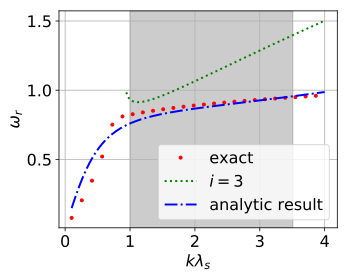

In [26]:
fig = plt.figure(figsize=(5,4))
ax1 = plt.subplot()
ax1.set_xlabel('$k\lambda_s$')
ax1.set_ylabel(r'$\omega_r$')
b_kw = wi_list/abs(wr_list/2/np.pi)
ax1.plot(kls_list[::8],wr_list[::8],'.',color='red',label='exact')
# ax1.plot(kls_list,wr_ex5_list,'-',color='black',label='$i=5$')
# ax1.plot(kls_list,wr_ex4_list,'--',color='blue',label='$i=4$')
ax1.plot(kls_list,wr_ex3_list,':',color='green',label='$i=3$')
ax1.plot(kls_list,PDR_analytic2(k_list),'-.',color='blue',label='analytic result')
# ax1.plot(kls_list,PDR_analytic(k_list),'--',color='black',label='analytic result')
# ax1.plot(kls_list,PDR_analytic(k_list),':',color='green',label='$i=3$')
ax1.axvspan(kls_list[b_kw>-1][0],kls_list[b_kw>-1][-1],color='black',alpha=0.2)
# plt.title(r"$\kappa_s = $"+str(kappa_s)+"; $\kappa_f = \infty$"+"; $T = $"+str(T)+"; $n_s$ = "+str(n_s))
ax1.grid()
ax1.legend(loc='lower right')
# plt.savefig('./figs/fig5.pdf',bbox_inches = 'tight')
plt.show()

- analytic and numerical solutions

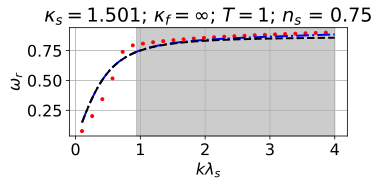

In [68]:
fig = plt.figure(figsize=(5,2))
ax1 = plt.subplot()
ax1.set_xlabel('$k\lambda_s$')
ax1.set_ylabel(r'$\omega_r$')
b_kw = wi_list/abs(wr_list/2/np.pi)
ax1.plot(kls_list[::8],wr_list[::8],'.',color='red',label='exact result')
ax1.axvspan(kls_list[b_kw>-1][0],kls_list[b_kw>-1][-1],color='black',alpha=0.2)
ax1.plot(kls_list,PDR_analytic2(k_list),'-.',color='blue',label='analytic result')
ax1.plot(kls_list,PDR_analytic(k_list),'--',color='black',label='analytic result')
plt.title(r"$\kappa_s = $"+str(kappa_s)+"; $\kappa_f = \infty$"+"; $T = $"+str(T)+"; $n_s$ = "+str(n_s))
ax1.grid()
# plt.yscale('log')
# ax1.legend(loc='lower right')
# plt.savefig('./figs/fig_analytic_exact_a.eps',bbox_inches = 'tight')
plt.show()

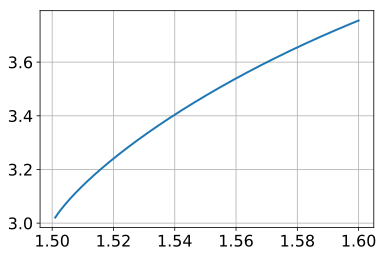

In [174]:
ks = np.linspace(1.501,1.6,num=200)
a = 3+4*np.tan(ks*np.pi)*np.sqrt(np.pi)*sp.gamma(ks+1)/sp.gamma(ks-1.5)*np.log(ks-1.5)*(ks-1.5)
# a = 3+4*np.sqrt(np.pi)*sp.gamma(ks+1)/sp.gamma(ks-1.5)
plt.plot(ks,a)
# plt.plot(ks,b,'--')
plt.grid()
plt.show()

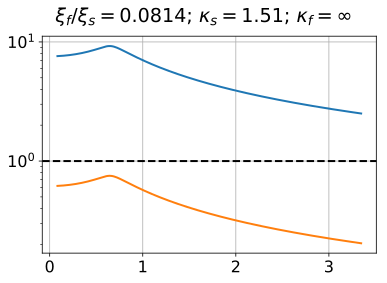

In [107]:
zeta_s_list = wr_list/k_list/v_s
zeta_f_list = wr_list/k_list/v_f
plt.plot(k_list,zeta_s_list)
plt.plot(k_list,zeta_f_list)
plt.axhline(1,linestyle='--',color='black')
plt.yscale('log')
plt.suptitle(r"$\xi_f/\xi_s = $"+str(round(v_s/v_f,4))+"; $\kappa_s = $"+str(kappa_s)+"; $\kappa_f = \infty$")
plt.grid()

In [195]:
print(zeta_f_list)

[0.61869288 0.61964579 0.62077232 0.62207423 0.62355358 0.62521277
 0.62705449 0.62908179 0.63129806 0.63370707 0.63631297 0.63912031
 0.64213408 0.64535965 0.64880283 0.65246983 0.6563672  0.66050177
 0.66488054 0.66951039 0.67439783 0.67954837 0.68496573 0.69065053
 0.69659822 0.70279602 0.70921798 0.71581756 0.72251633 0.72918745
 0.73563335 0.74156035 0.74656199 0.75013732 0.75177759 0.7511197
 0.74808495 0.74289537 0.73596191 0.72774134 0.71864186 0.70898809
 0.6990221  0.68891803 0.67879853 0.66874877 0.65882716 0.64907305
 0.63951231 0.63016121 0.62102919 0.61212088 0.60343738 0.59497739
 0.58673788 0.57871458 0.57090246 0.56329593 0.55588906 0.54867577
 0.54164991 0.53480533 0.52813597 0.52163589 0.5152993  0.50912054
 0.50309417 0.49721491 0.49147769 0.48587761 0.48040996 0.47507024
 0.46985409 0.46475735 0.45977603 0.45490629 0.45014446 0.445487
 0.44093055 0.43647186 0.43210781 0.42783543 0.42365185 0.41955432
 0.4155402  0.41160696 0.40775216 0.40397347 0.40026864 0.3966355

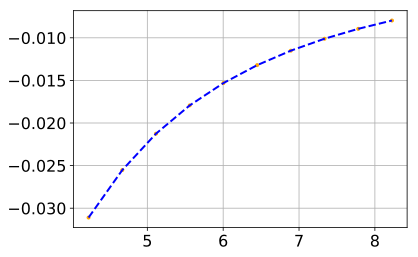

In [90]:
def zs_ex_mace_re(zeta,kappa,order):
    a = -0.5/zeta**2
    s = 0
    for n in np.arange(order):
        kfactor = 1.0
        for nn in np.arange(n):
            kfactor *= (2*kappa-2*nn-3)
        s += sp.factorial2(2*n+1)*kappa**(n)/kfactor/zeta**(2*n)
    return a*s

def zs_ex_mace_im(zeta,kappa):
    fac = -1j*np.sqrt(np.pi)*sp.gamma(kappa+1)/kappa**1.5/np.cos(kappa*np.pi)/sp.gamma(kappa-0.5)
    z = -1j*zeta/np.sqrt(kappa)
    r1 = (z-1)**(-kappa-1)
    r2 = (z+1)**(-kappa-1)
    return (zeta*fac*r1*r2).real

zeta_list = np.linspace(np.sqrt(kappa_s)+3,np.sqrt(kappa_s)+7,num=10)
ze_list = []
for zeta in zeta_list:
    ze_list.append((1-0.5/kappa_s+zeta*dispersion_function(zeta,kappa_s).real))

plt.plot(zeta_list,ze_list,'.',color='orange')
plt.plot(zeta_list,zs_ex(zeta_list,kappa_s,10),'--',color='blue')
# plt.plot(zeta_list,zs_ex_mace_re(zeta_list,kappa_s,10),'--',color='purple')
plt.grid()
plt.show()

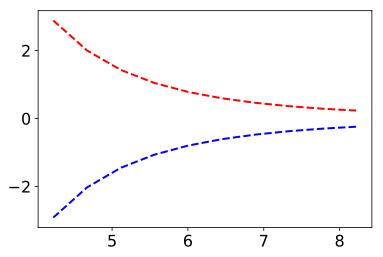

In [91]:
plt.plot(zeta_list,zs_ex_mace_re(zeta_list,kappa_s,10),'--',color='blue')
plt.plot(zeta_list,zs_ex_mace_im(zeta_list,kappa_s),'--',color='red')